In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint
from datetime import datetime

sys.path.append('../..')

In [29]:
# from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent
from model.amm.trade_strategies import general_arbitrage, invest_all
from model.amm.global_state import GlobalState
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.exchange import Exchange
from model import run
import model.plot_utils as pu

class CEXDummy(Exchange):
    def __init__(self, tokens: dict[str: float], unique_id='dummy exchange'):
        self.prices = tokens
        self.liquidity = {tkn: 0 for tkn in tokens}
        self.asset_list = list(tokens.keys())
        self.unique_id = unique_id
    
    def price(self, tkn):
        return self.prices[tkn]
    
    def buy_spot(self, tkn_buy, tkn_sell, fee=0):
        return self.price(tkn_buy) / self.price(tkn_sell)
    
    def sell_spot(self, tkn_sell, tkn_buy, fee=0):
        return self.price(tkn_sell) / self.price(tkn_buy)
    
    def swap(
        self,
        agent: Agent, 
        tkn_buy: str, 
        tkn_sell: str,
        buy_quantity: float=0,
        sell_quantity: float=0
    ):
        if buy_quantity:
            sell_quantity = self.calculate_sell_from_buy(tkn_buy, tkn_sell, buy_quantity)
        elif sell_quantity:
            buy_quantity = self.calculate_buy_from_sell(tkn_buy, tkn_sell, sell_quantity)
            
        if tkn_buy not in agent.holdings:
            agent.holdings[tkn_buy] = 0
            
        agent.holdings[tkn_sell] -= sell_quantity
        agent.holdings[tkn_buy] += buy_quantity
        self.liquidity[tkn_sell] += sell_quantity
        self.liquidity[tkn_buy] -= buy_quantity
        
    def calculate_buy_from_sell(self, tkn_buy, tkn_sell, sell_quantity):
        return sell_quantity * self.price(tkn_sell) / self.price(tkn_buy)
    
    def calculate_sell_from_buy(self, tkn_sell, tkn_buy, buy_quantity):
        buy_quantity * self.price(tkn_buy) / self.price(tkn_sell)

rebase_amount = 1000        
def rebase(tkn: str):
    def evolve(state: GlobalState):
        tkn_holders = {
            pool: pool.liquidity[tkn]
            for pool in state.pools.values()
        }
        tkn_holders.update({
            agent: agent.holdings[tkn]
            for agent in state.agents.values()
        })
        total_supply = sum(tkn_holders.values())
        awards = 0
        for holder in tkn_holders:
            if isinstance(holder, Agent):
                awards += rebase_amount * holder.holdings[tkn] / total_supply
                holder.holdings[tkn] += rebase_amount * holder.holdings[tkn] / total_supply
            elif isinstance(holder, Exchange):
                awards += rebase_amount * holder.liquidity[tkn] / total_supply
                holder.liquidity[tkn] += rebase_amount * holder.liquidity[tkn] / total_supply
        if (state.time_step % 100 == 0):
            print(total_supply)
            print(awards)
        return state
    return evolve

binance = CEXDummy({'S1': 1, 'S2': 1}, 'binance')
stableswap = StableSwapPoolState(
    tokens={'S1': 1000000, 'S2': 1000000},
    amplification=100,
    trade_fee=0.001,
    unique_id='stableswap'
)
LP = Agent(
    holdings={'S1': rebase_amount},
    trade_strategy=invest_all('stableswap'),
    unique_id='LP'
)
non_LP = Agent(
    holdings={'S1': rebase_amount},
    trade_strategy=None,
    unique_id='non_LP'
)
arbitrageur = Agent(
    holdings={'S1': 1000000, 'S2': 1000000},
    trade_strategy=general_arbitrage([stableswap, binance])
)
initial_state = GlobalState(
    pools={'stableswap': stableswap, 'binance': binance},
    agents={'LP': LP, 'non_LP': non_LP, 'arbitrageur': arbitrageur},
    external_market={'S1': 1, 'S2': 1},
    evolve_function=rebase('S1')
)

Generated default config [{'exchanges': {'stableswap': ('S1', 'S2'), 'binance': ('S1', 'S2')}, 'buffer': 0.001}]


In [30]:
events = run.run(initial_state, time_steps=1000)

Starting simulation...
2101000.000000004
1000.0
2200999.999999997
1000.0
2300999.9999999898
1000.0
2400999.9999999823
1000.0000000000001
2500999.999999976
1000.0
2600999.9999999683
1000.0
2700999.999999961
1000.0
2800999.999999954
1000.0
2900999.999999947
1000.0
3000999.9999999395
1000.0
Execution time: 1.033 seconds.


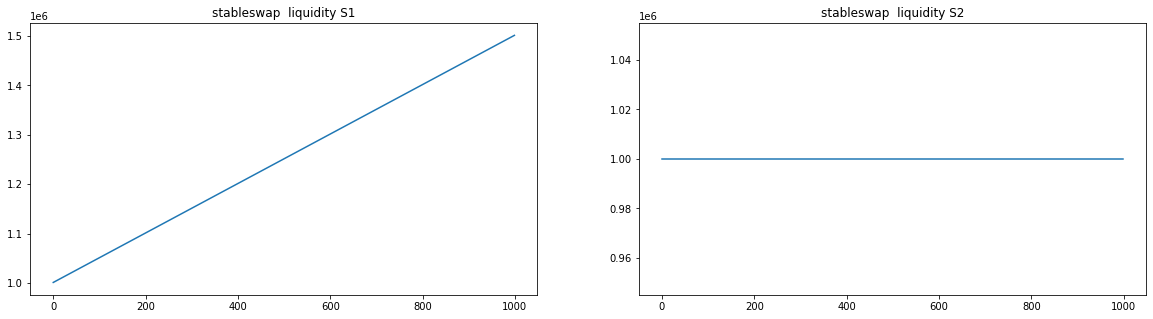

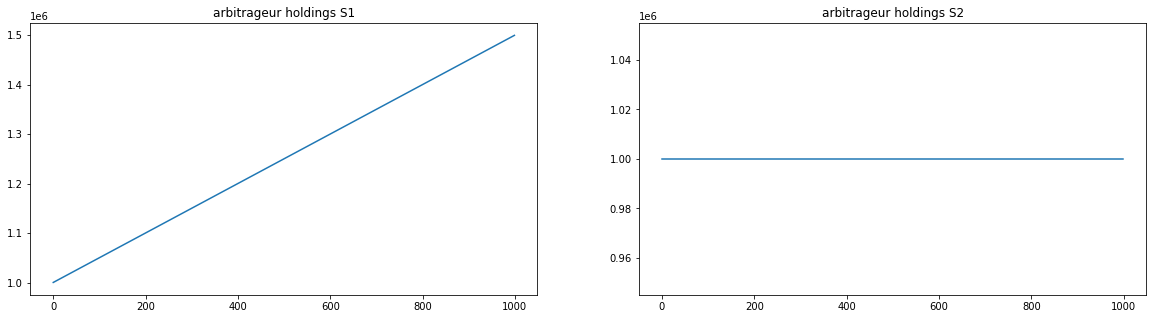

In [31]:
pu.plot(events, pool='stableswap', prop='liquidity')
pu.plot(events, agent='arbitrageur', prop='holdings', key=['S1', 'S2'])

In [32]:
impermanent_loss = [
    (1 - event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market)
    / sum(event.agents['non LP'].holdings.values())) * 100
    for event in events
]
total_supply = [
    sum([
        event.pools['stableswap'].liquidity['S1'], 
        event.agents['arbitrageur'].holdings['S1'], 
        event.agents['LP'].holdings['S1'], 
        event.agents['non LP'].holdings['S1']
    ]) for event in events
]


AttributeError: 'StableSwapPoolState' object has no attribute 'cash_out'

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, impermanent_loss)
plt.title

In [ ]:
events[2].agents['LP'].holdings

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, [event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market) for event in events])
plt.plot(total_supply, [sum(event.agents['non LP'].holdings.values()) for event in events])

In [ ]:
(
    events[-1].pools['stableswap'].liquidity['S1']
    + events[-1].agents['LP'].holdings['S1']
    + events[-1].agents['non LP'].holdings['S1']
    + events[-1].agents['arbitrageur'].holdings['S1']
)

In [ ]:
events[-1].agents['non LP'].holdings['S1']